# DBSCAN - Exercícios

Repositório original com conteúdo teórico:  
https://github.com/silvaan/unsupervised-learning/blob/main/04%20-%20DBSCAN.ipynb

In [ ]:
!pip install dtaidistance

In [35]:
# Célula de importação de bibliotecas
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from dtaidistance import dtw
import plotly.express as px

np.random.seed(1)
# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')

In [36]:
class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0

    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        # elif self.metric == '...':
            # distance = ...
        else:
            raise ValueError("Métrica não suportada")
        return distances

    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]

    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

In [37]:
def plot_k_distance(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

In [38]:
def generate_concentric_spheres(radii=[3, 15], n_samples_per_sphere=1000, noise=0.2, random_state=42):
    """
    Gera pontos em 3 esferas concêntricas no espaço 3D.
    - radii: lista com os raios das esferas
    - n_samples_per_sphere: pontos em cada esfera
    - noise: variação radial para "espessura" da casca
    """
    rng = np.random.default_rng(random_state)
    X, y = [], []

    for i, r in enumerate(radii):
        # amostrar ângulos uniformemente
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)       # ângulo azimutal
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)       # cos(theta)
        theta = np.arccos(costheta)                               # ângulo polar

        # raio com ruído
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)

        # coordenadas cartesianas
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)

        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

X_spheres, y_spheres = generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4)

scaler = StandardScaler()
X_spheres = scaler.fit_transform(X_spheres)

In [39]:
fig = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color_continuous_scale=px.colors.qualitative.Vivid,
)
fig.update_traces(marker=dict(size=3))
fig.show()

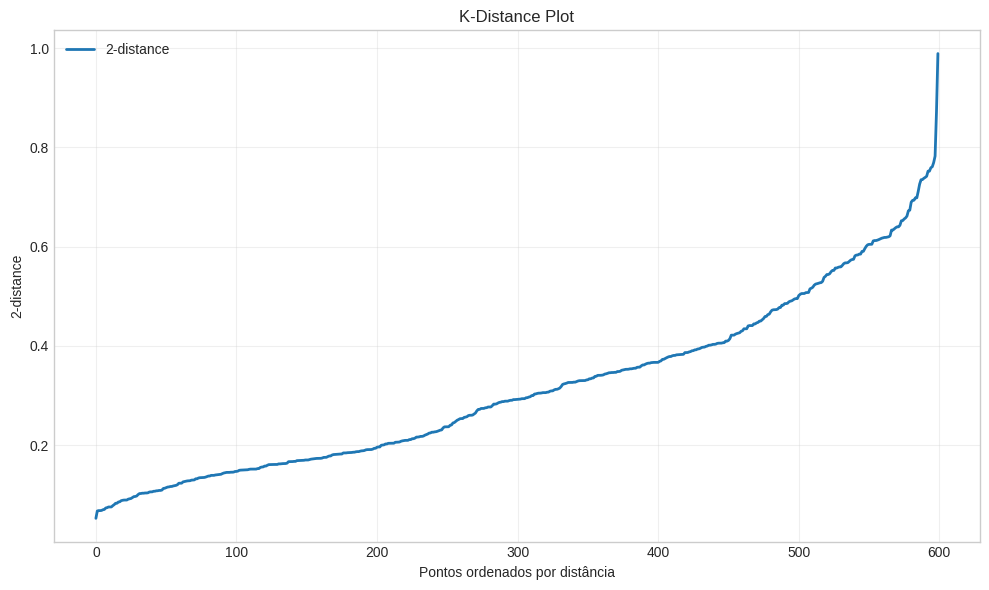

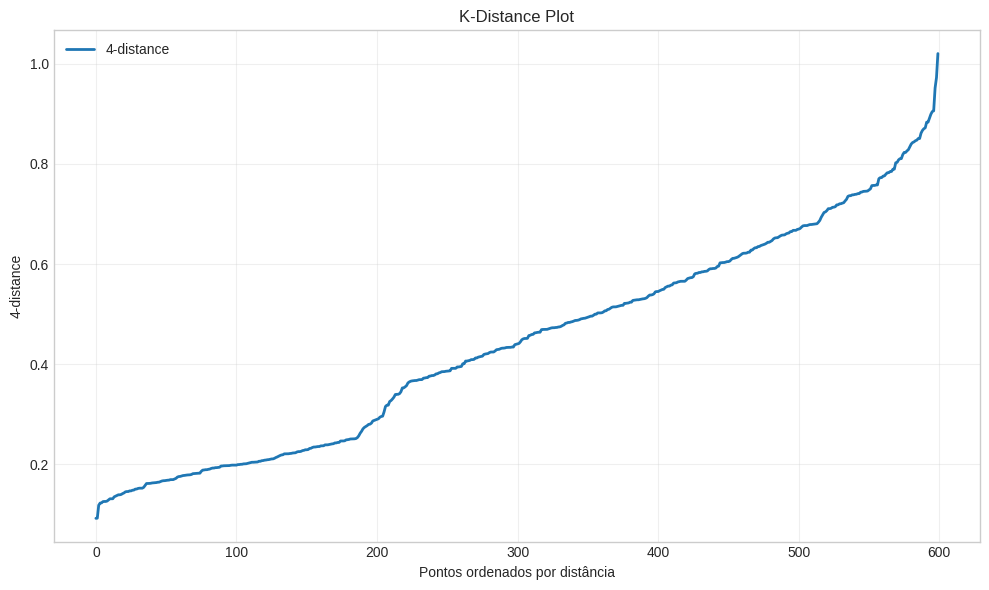

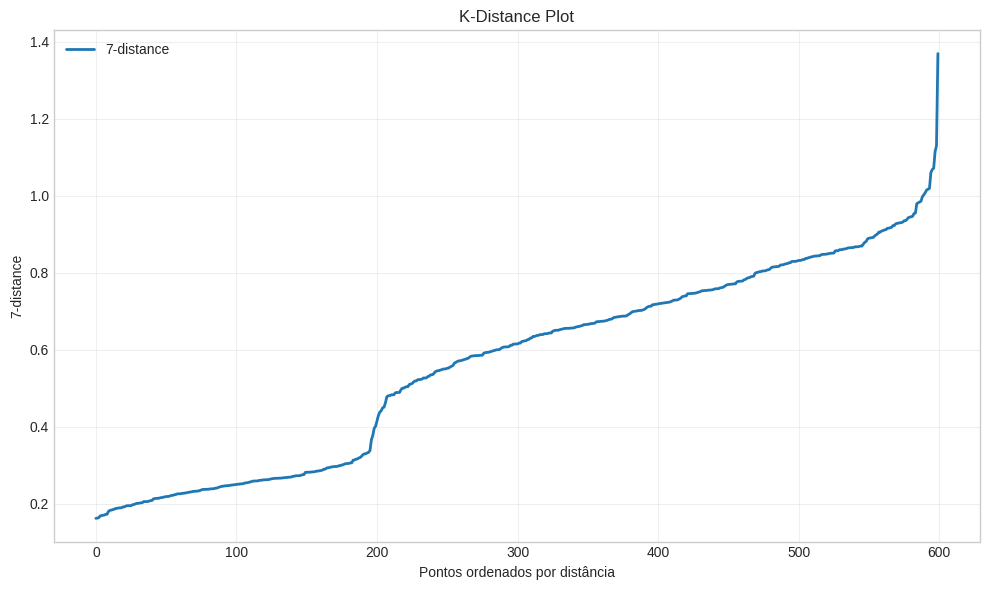

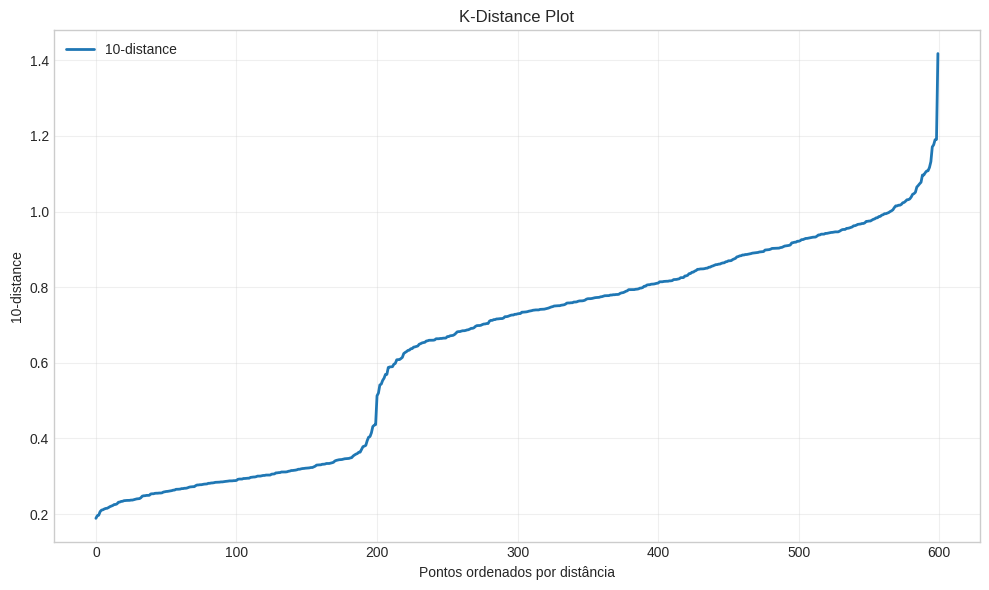

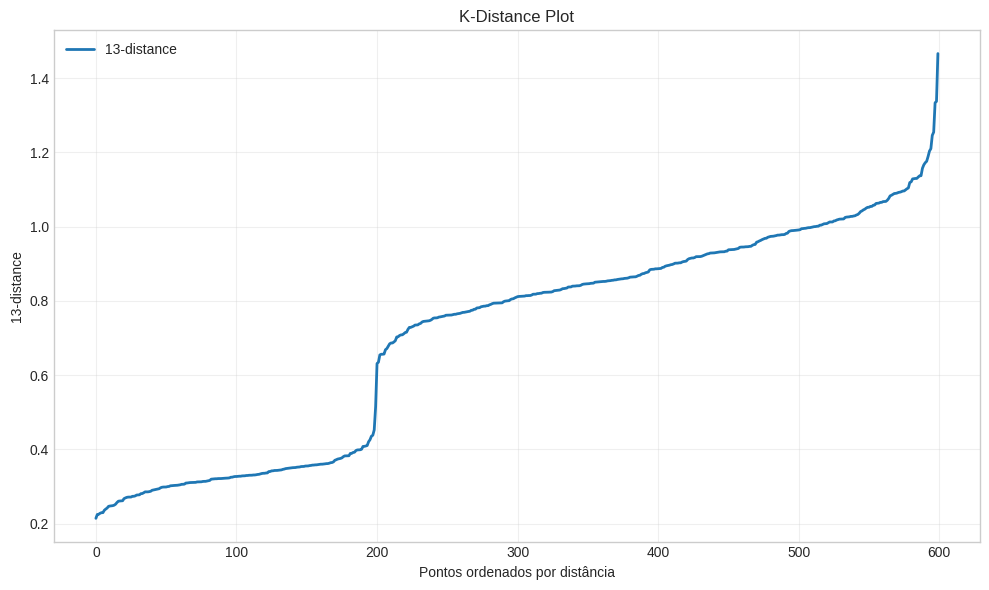

In [40]:
# 1. Plotar o K-Distance para diferentes valores de min_pts e sugerir um intervalo adequado para eps.

min_pts_values = [3, 5, 8, 11, 14]

for i, min_pts in enumerate(min_pts_values):
    plot_k_distance(X_spheres, min_pts=min_pts)
    print("")

Para cada valor de minPts, segue a distância epsilon que está no meio próximo das curvas de cotovelo:

3 minPts: 0.67  
5 minPts: 0.4  
8 minPts: 0.5  
11 minPts: 0.7  
14 minPts: 0.8

In [41]:
# 2. Selecionar os melhores parâmetros de min_pts e eps.

# Lista de minPts e epsilons
eps_list = [0.67, 0.4, 0.5, 0.7, 0.8]
min_pts_list = [3, 5, 8, 11, 14]

for i in range(5):
  dbscan_selected = DBSCAN(eps=eps_list[i], min_pts=min_pts_list[i])
  labels_selected = dbscan_selected.fit_predict(X_spheres)

  # Análise detalhada
  unique_labels = np.unique(labels_selected)
  n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
  n_noise = np.sum(labels_selected == -1)
  n_core_samples = len(dbscan_selected.core_samples_)

  print(f"Resultados do DBSCAN (eps={eps_list[i]}, min_pts={min_pts_list[i]}):")
  print(f"- Número de clusters encontrados: {n_clusters}")
  print(f"- Número de pontos de ruído: {n_noise}")
  print(f"- Número de core samples: {n_core_samples}")
  print(f"- Labels únicos: {unique_labels}\n")

Resultados do DBSCAN (eps=0.67, min_pts=3):
- Número de clusters encontrados: 3
- Número de pontos de ruído: 9
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]

Resultados do DBSCAN (eps=0.4, min_pts=5):
- Número de clusters encontrados: 17
- Número de pontos de ruído: 270
- Número de core samples: 17
- Labels únicos: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

Resultados do DBSCAN (eps=0.5, min_pts=8):
- Número de clusters encontrados: 6
- Número de pontos de ruído: 336
- Número de core samples: 6
- Labels únicos: [-1  0  1  2  3  4  5]

Resultados do DBSCAN (eps=0.7, min_pts=11):
- Número de clusters encontrados: 7
- Número de pontos de ruído: 211
- Número de core samples: 7
- Labels únicos: [-1  0  1  2  3  4  5  6]

Resultados do DBSCAN (eps=0.8, min_pts=14):
- Número de clusters encontrados: 2
- Número de pontos de ruído: 149
- Número de core samples: 2
- Labels únicos: [-1  0  1]



Note que dos resultados obtidos, todos ajustados para terem 3 clusters, os parâmetros aparentemente que obtiveram o melhor desempenho foram epsilon = 0.67 e miínimo de pontos = 3

In [42]:
# 3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de eps e min_samples.
eps=0.67
min_pts=3

dbscan = DBSCAN(eps=eps, min_pts=min_pts)
labels = dbscan.fit_predict(X_spheres)

string_labels = [f"Cluster {l}" if l!= -1 else 'Ruído' for l in labels]
unique_clusters = sorted([label for label in np.unique(labels) if label != -1])
colors = px.colors.qualitative.Vivid
color_map = {"Ruído": "black"}
for i, cluster in enumerate(unique_clusters):
  color_map[f'Cluster {cluster}'] = colors[i % len(colors)]
symbol_map = {"Ruído": 'cross', **{f'Cluster {c}': 'circle' for c in unique_clusters}}

fig = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color=string_labels,
    color_discrete_map=color_map,
    symbol=string_labels,
    symbol_map=symbol_map,
    title=f"Clustering DBSCAN em 3d, min_pts={min_pts} e eps={eps}"
)

fig.update_traces(marker=dict(size=3))
fig.show()

Apesar de ter sido o par de pontos mínimos e epsilon com menor quantidade de pontos de ruído, o DBSCAN considerou a grande maioria dos pontos da camada externa e da camada intermediária como sendo do mesmo cluster, enquanto a camada interna foi considerada seu próprio cluster.

### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

In [43]:
# 1. Implemente a distância radial e use-a no DBSCAN.
# Classe DBSCAN com distância radial implementada

class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0

    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        elif self.metric == 'radial':
            radii = np.linalg.norm(X, axis=1) # Calcula o raio de cada ponto em relação à origem
            distances = np.abs(radii[:, np.newaxis] - radii) # Diferença absoluta entre os raios de todos os pares de pontos
        else:
            raise ValueError("Métrica não suportada")
        return distances

    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]

    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

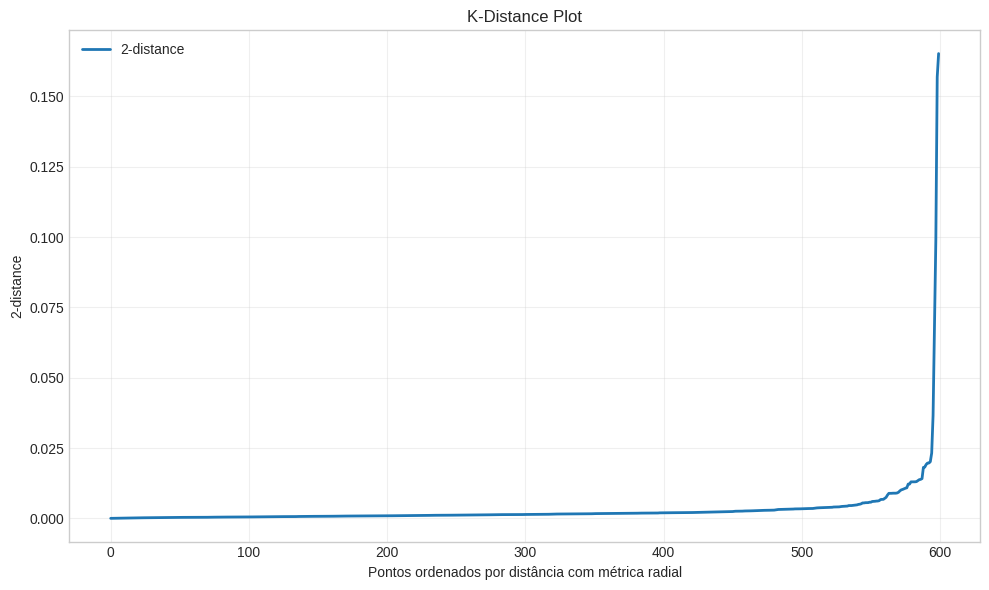

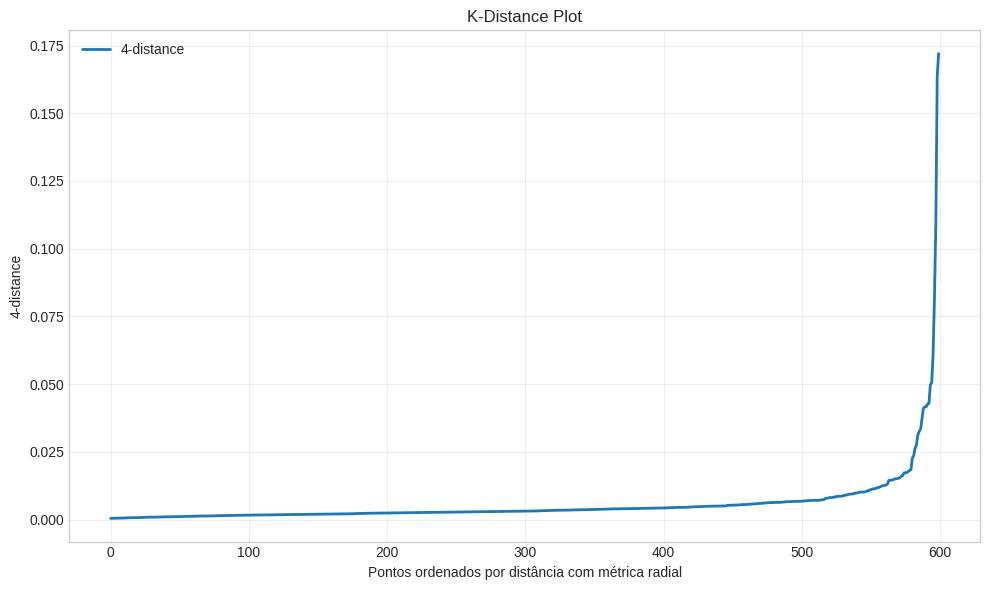

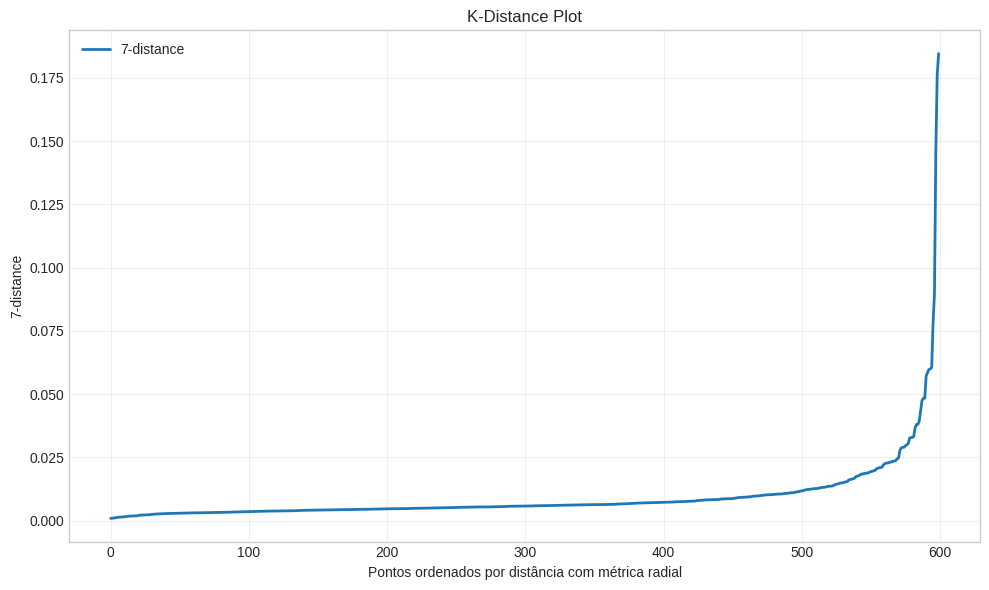

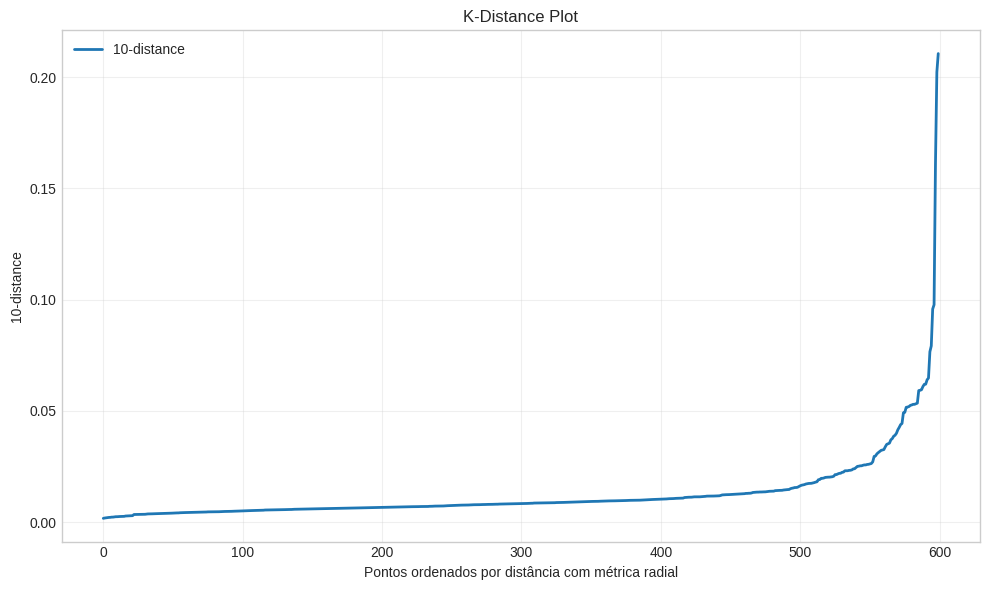

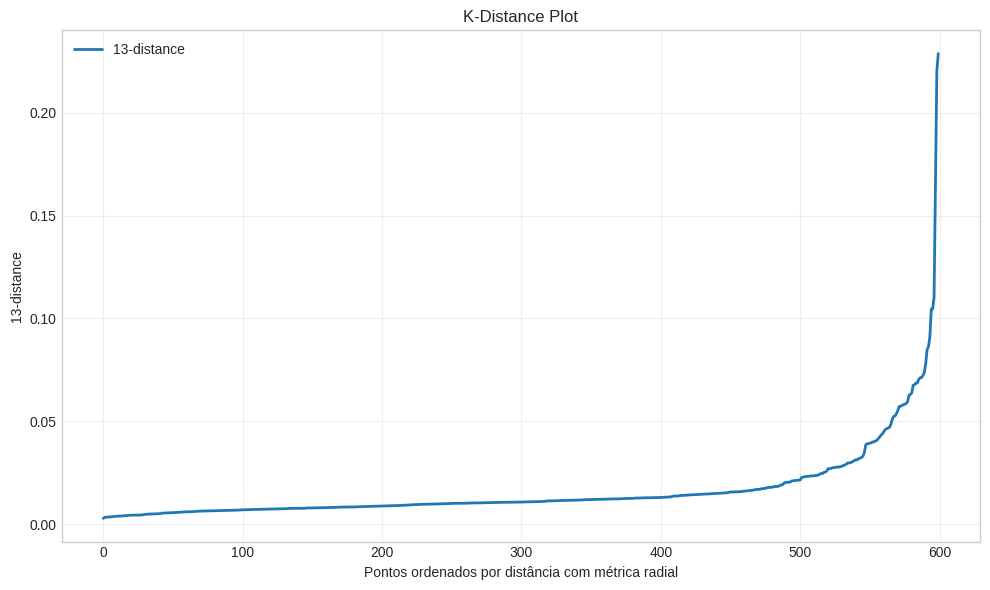

In [44]:
# 2. Plote o K-Distance radial para sugerir eps.

def radial_magnitude_distance(p1, p2):
    r1 = np.linalg.norm(p1)
    r2 = np.linalg.norm(p2)

    return np.abs(r1 - r2)

def plot_k_distance_radial(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric=radial_magnitude_distance)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância com métrica radial")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


min_pts_values = [3, 5, 8, 11, 14]

for i, min_pts in enumerate(min_pts_values):
    plot_k_distance_radial(X_spheres, min_pts=min_pts)
    print("")

In [45]:
# 3. Teste combinações de eps e min_samples.

# Lista de minPts e epsilons
eps_list = [0.025, 0.04, 0.05, 0.05, 0.05]
min_pts_list = [3, 5, 8, 11, 14]

for i in range(5):
  dbscan_selected = DBSCAN(eps=eps_list[i], min_pts=min_pts_list[i], metric="radial")
  labels_selected = dbscan_selected.fit_predict(X_spheres)

  # Análise detalhada
  unique_labels = np.unique(labels_selected)
  n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
  n_noise = np.sum(labels_selected == -1)
  n_core_samples = len(dbscan_selected.core_samples_)

  print(f"Resultados do DBSCAN (eps={eps_list[i]}, min_pts={min_pts_list[i]}):")
  print(f"- Número de clusters encontrados: {n_clusters}")
  print(f"- Número de pontos de ruído: {n_noise}")
  print(f"- Número de core samples: {n_core_samples}")
  print(f"- Labels únicos: {unique_labels}\n")

Resultados do DBSCAN (eps=0.025, min_pts=3):
- Número de clusters encontrados: 5
- Número de pontos de ruído: 4
- Número de core samples: 5
- Labels únicos: [-1  0  1  2  3  4]

Resultados do DBSCAN (eps=0.04, min_pts=5):
- Número de clusters encontrados: 3
- Número de pontos de ruído: 7
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]

Resultados do DBSCAN (eps=0.05, min_pts=8):
- Número de clusters encontrados: 3
- Número de pontos de ruído: 4
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]

Resultados do DBSCAN (eps=0.05, min_pts=11):
- Número de clusters encontrados: 3
- Número de pontos de ruído: 4
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]

Resultados do DBSCAN (eps=0.05, min_pts=14):
- Número de clusters encontrados: 3
- Número de pontos de ruído: 9
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]



In [46]:
# 4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.
# 5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

# Testando com eps=0.05 e min_pts com valor 8 e 11, que obtiveram o menor número de pontos de ruído e 3 clusters em cada um

for min_pts in [8, 11]:
  dbscan = DBSCAN(eps=0.05, min_pts=min_pts,  metric="radial")
  labels = dbscan.fit_predict(X_spheres)

  string_labels = [f"Cluster {l}" if l!= -1 else 'Ruído' for l in labels]
  unique_clusters = sorted([label for label in np.unique(labels) if label != -1])
  colors = px.colors.qualitative.Vivid
  color_map = {"Ruído": "black"}
  for i, cluster in enumerate(unique_clusters):
    color_map[f'Cluster {cluster}'] = colors[i % len(colors)]
  symbol_map = {"Ruído": 'cross', **{f'Cluster {c}': 'circle' for c in unique_clusters}}

  fig = px.scatter_3d(
      x=X_spheres[:, 0],
      y=X_spheres[:, 1],
      z=X_spheres[:, 2],
      color=string_labels,
      color_discrete_map=color_map,
      symbol=string_labels,
      symbol_map=symbol_map,
      title=f"Clustering DBSCAN em 3d com métrica radial, min_pts={min_pts} e eps={0.05}"
  )

  fig.update_layout(legend_title_text='Legenda')
  fig.update_traces(marker=dict(size=3))
  fig.show()
  print("")

Veja que, diferente do uso do DBSCAN com métrica euclidiana no exercício 1, no qual o algoritmo não conseguiu distinguir entre as esferas externa e média, agora, utilizando a métrica radial, conseguiu fazer isso com sucesso, além de reduzir drasticamente o número de ruídos.  

Além disso, um ponto a se destacar foi que, considerando o número de clusters e ruídos encontrados nas quantidades de pontos mínimos testados, apenas o algoritmo com mínimo de pontos igual a 3 que não conseguiu distinguir corretamente entre as 3 esferas, mostrando que a métrica funciona corretamente para várias quantidades de pontos mínimos.

Sobre o funcionamento da métrica radial, ela funciona melhor nessa situação das esferas justamente pelo fato dos pontos de cada esfera possuírem valores de raios semelhantes, e a métrica radial leva em conta isso, enquanto que a métrica euclidiana considera a distância mais curta entre dois pontos no espaço, o que não funciona adequadamente nessa situação devido à proximidade entre as esferas externa e média, ao mesmo tempo em que os pontos dessas esferas estão mais espalhados.

### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

O **DTW (Dynamic Time Warping)** mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:
```python
from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
````

**Tarefas:**
1. Use o dataset de senóides com variação e **anomalias simuladas**.  
2. Adicione a métrica DTW no DBSCAN.
3. Experimente diferentes valores de `eps` e `min_samples` até que o modelo consiga separar bem séries normais das anômalas.  
4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (`label = -1`).  

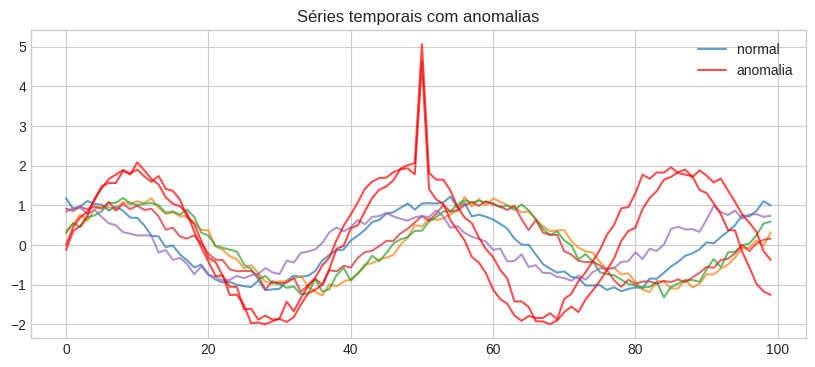

In [47]:
def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=2, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)

    # séries normais: senóide com amplitude e frequência ligeiramente diferentes
    for _ in range(n_series):
        amp = rng.uniform(0.8, 1.2)         # amplitude
        freq = rng.uniform(0.9, 1.1)        # frequência
        phase = rng.uniform(0, 0.5*np.pi)   # pequena defasagem
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
        y.append(0)  # normal

    # outliers: picos ou deslocamentos fortes
    for _ in range(n_outliers):
        amp = rng.uniform(1.5, 2.0)         # amplitude anômala
        freq = rng.uniform(1.2, 1.5)        # frequência anômala
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5:
            series[length//2] += 3  # pico
        else:
            series += rng.normal(2.0, 0.5)  # deslocamento
        X.append(series)
        y.append(-1)  # anomalia

    return np.array(X), np.array(y)

X_series, y_series = generate_time_series_dataset()

plt.figure(figsize=(10,4))
for i in range(5):
    plt.plot(X_series[i], alpha=0.7, label="normal" if i==0 else "")
for i in range(-2,0):
    plt.plot(X_series[i], alpha=0.7, color="red", label="anomalia" if i==-1 else "")
plt.title("Séries temporais com anomalias")
plt.legend()
plt.show()

In [48]:
# 1. Adicione a métrica DTW no DBSCAN.
# Classe DBSCAN com métrica DTW implementada

class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0

    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        elif self.metric == 'radial':
            radii = np.linalg.norm(X, axis=1)                                   # Calcula o raio de cada ponto em relação à origem
            distances = np.abs(radii[:, np.newaxis] - radii)                    # Diferença absoluta entre os raios de todos os pares de pontos
        elif self.metric == 'dtw':
            n = len(X)                                                          # número de séries
            distances = np.zeros((n, n))                                        # matriz de distâncias

            for i in range(n):
              for j in range(i+1, n):
                dist = dtw.distance_fast(X[i], X[j])                            # distância DTW
                distances[i, j] = distances[j, i] = dist                        # matriz simétrica
        else:
            raise ValueError("Métrica não suportada")
        return distances

    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        return np.where(distance_matrix[point_idx] <= self.eps)[0]

    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

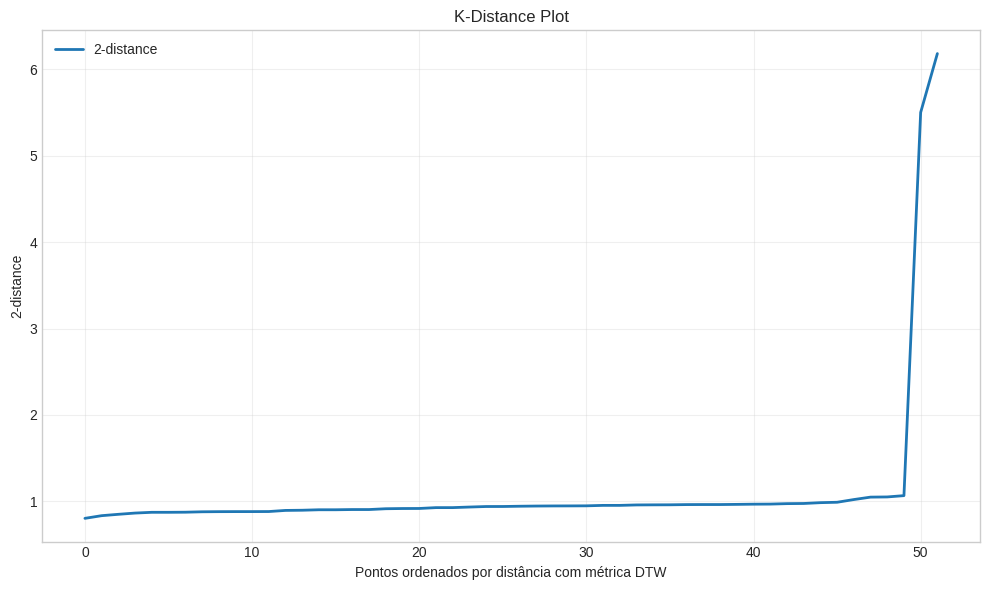

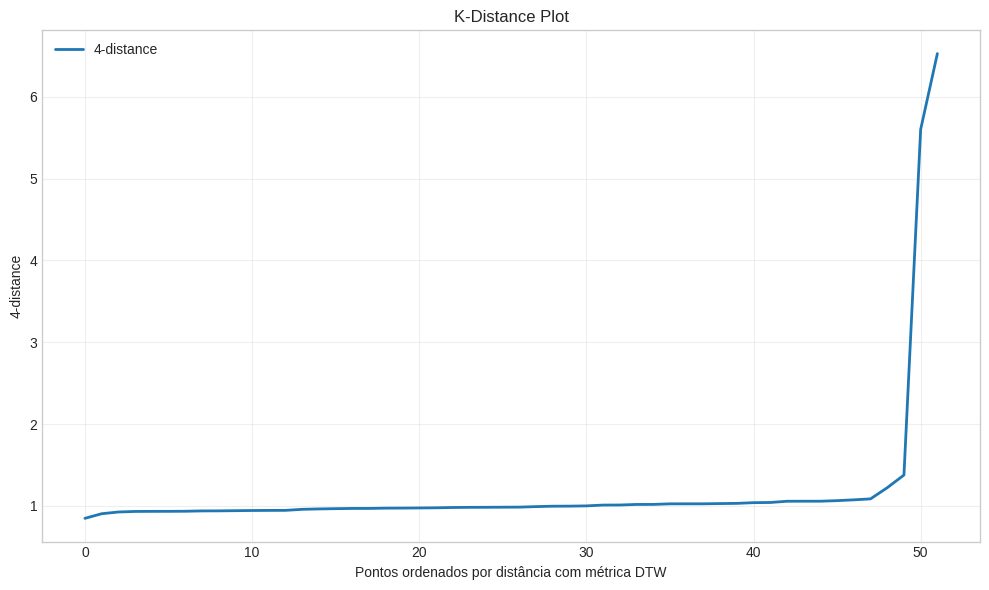

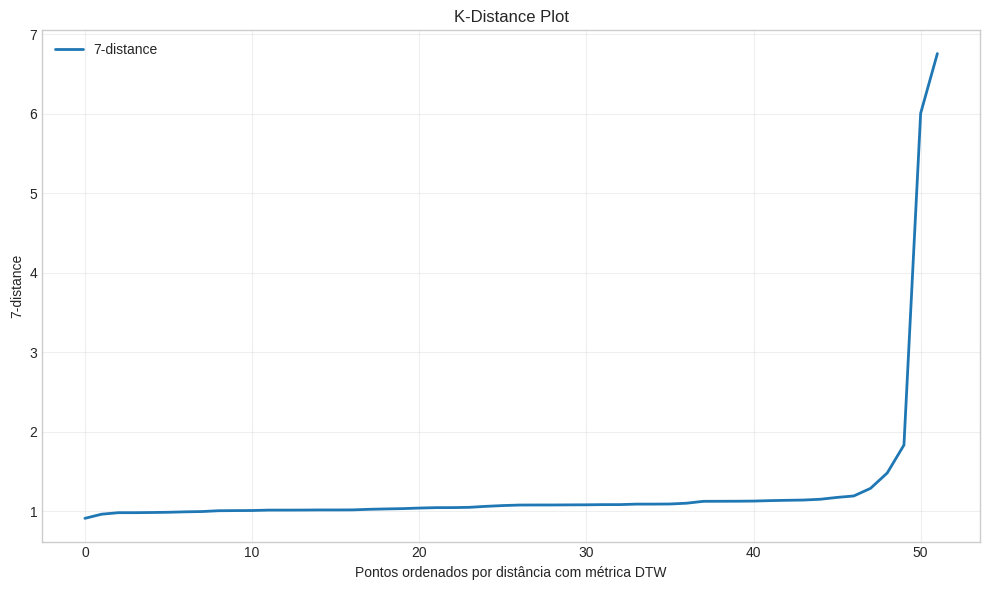

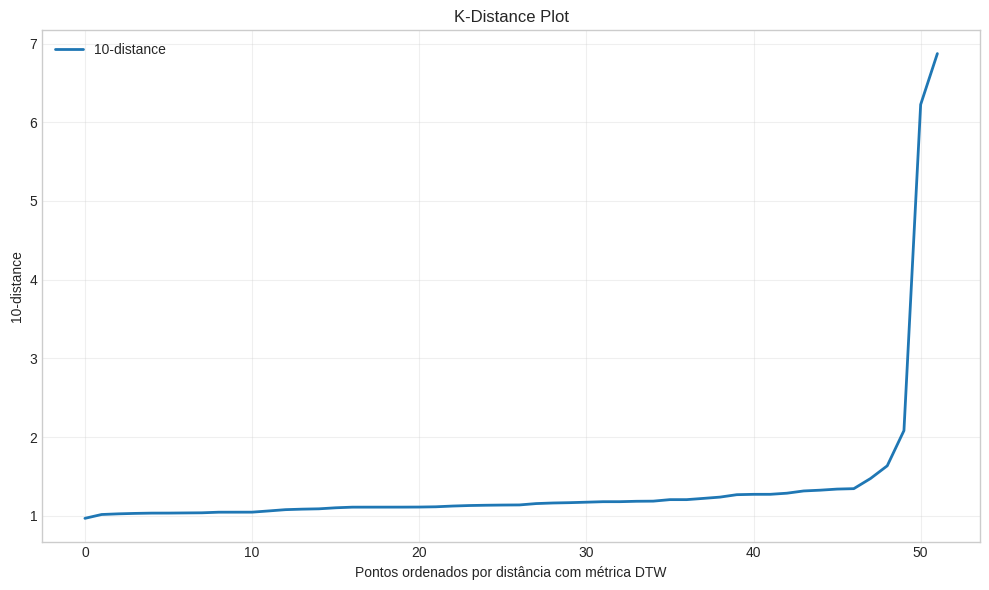

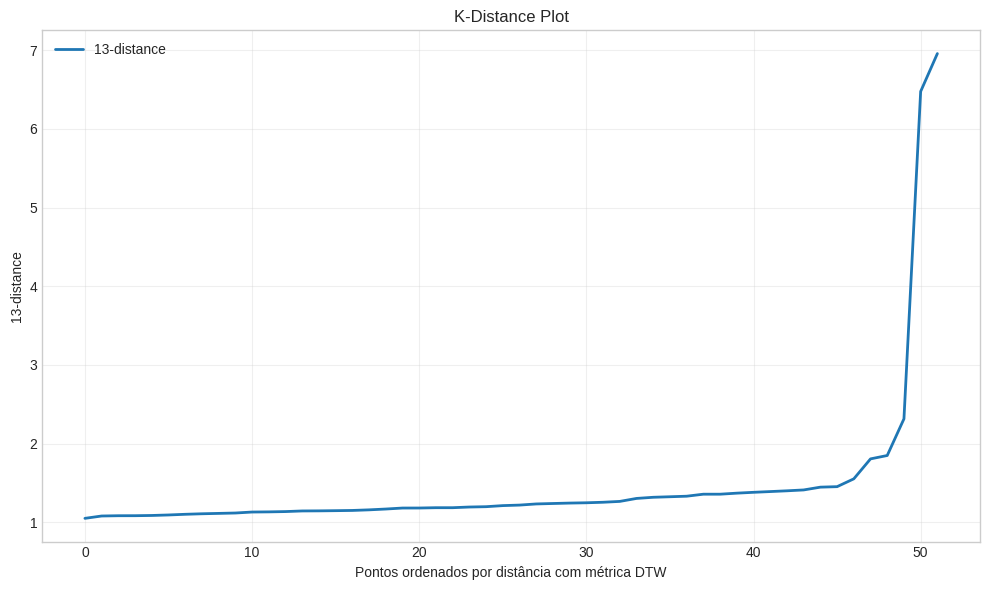

In [49]:
# 3. Experimente diferentes valores de eps e min_samples até que o modelo consiga separar bem séries normais das anômalas.

# Plotando o K-Distance para sugerir eps

def dtw_distance(p1, p2):
    return dtw.distance_fast(p1, p2)

def plot_k_distance_dtw(X, min_pts, title="K-Distance Plot"):
    """Plota o gráfico K-Distance usando sklearn.NearestNeighbors."""
    k = int(min_pts - 1)

    nn = NearestNeighbors(n_neighbors=k+1, metric=dtw_distance)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)

    kth_distances = distances[:, k]
    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance')
    plt.xlabel("Pontos ordenados por distância com métrica DTW")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


min_pts_values = [3, 5, 8, 11, 14]

for i, min_pts in enumerate(min_pts_values):
    plot_k_distance_dtw(X_series, min_pts=min_pts)
    print("")

In [50]:
# Lista de minPts e epsilons
eps_list = [1.1, 1.5, 1.5, 1.5, 1.7]
min_pts_list = [3, 5, 8, 11, 14]

for i in range(5):
  dbscan_selected = DBSCAN(eps=eps_list[i], min_pts=min_pts_list[i], metric="dtw")
  labels_selected = dbscan_selected.fit_predict(X_series)

  # Análise detalhada
  unique_labels = np.unique(labels_selected)
  n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
  n_noise = np.sum(labels_selected == -1)
  n_core_samples = len(dbscan_selected.core_samples_)

  print(f"Resultados do DBSCAN (eps={eps_list[i]}, min_pts={min_pts_list[i]}):")
  print(f"- Número de clusters encontrados: {n_clusters}")
  print(f"- Número de pontos de ruído: {n_noise}")
  print(f"- Número de core samples: {n_core_samples}")
  print(f"- Labels únicos: {unique_labels}\n")

Resultados do DBSCAN (eps=1.1, min_pts=3):
- Número de clusters encontrados: 1
- Número de pontos de ruído: 2
- Número de core samples: 1
- Labels únicos: [-1  0]

Resultados do DBSCAN (eps=1.5, min_pts=5):
- Número de clusters encontrados: 1
- Número de pontos de ruído: 2
- Número de core samples: 1
- Labels únicos: [-1  0]

Resultados do DBSCAN (eps=1.5, min_pts=8):
- Número de clusters encontrados: 1
- Número de pontos de ruído: 2
- Número de core samples: 1
- Labels únicos: [-1  0]

Resultados do DBSCAN (eps=1.5, min_pts=11):
- Número de clusters encontrados: 1
- Número de pontos de ruído: 2
- Número de core samples: 1
- Labels únicos: [-1  0]

Resultados do DBSCAN (eps=1.7, min_pts=14):
- Número de clusters encontrados: 1
- Número de pontos de ruído: 2
- Número de core samples: 1
- Labels únicos: [-1  0]



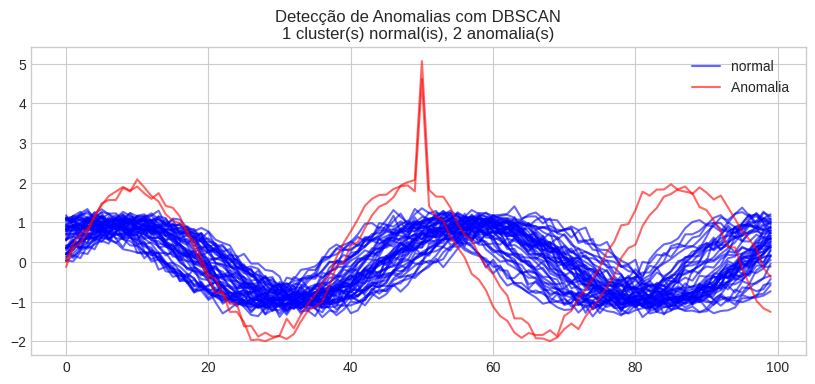

In [51]:
# 4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (label = -1).

dbscan = DBSCAN(eps=1.1, min_pts=3, metric="dtw")
labels = dbscan.fit_predict(X_series)

plt.figure(figsize=(10,4))

anomaly_mask = (labels == -1)
normal_mask = (labels != -1)

for i, series in enumerate(X_series[normal_mask]):
    plt.plot(series, color='blue', alpha=0.6, label="normal" if i==0 else "")
for i, series in enumerate(X_series[anomaly_mask]):
    plt.plot(series, color='red', alpha=0.6, label='Anomalia ' if i==0 else "")

unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(labels == -1)

plt.title(f'Detecção de Anomalias com DBSCAN\n{n_clusters} cluster(s) normal(is), {n_noise} anomalia(s)')
plt.legend()
plt.show()
